# L11_transient_Universe

1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import corner
import warnings; warnings.simplefilter('ignore')

C:\Users\carlo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data_file = '/Users/carlo/Desktop/Astrofisica/astrostatistics/astrostatistics_bicocca_2022/solutions/transient.npy'
data = np.load(data_file)

t        = data[:,0]  #first column: time
flux     = data[:,1]  #second column: flux
err_flux = data[:,2]  #third column: flux uncertainty

Text(0.5, 1.0, 'Data')

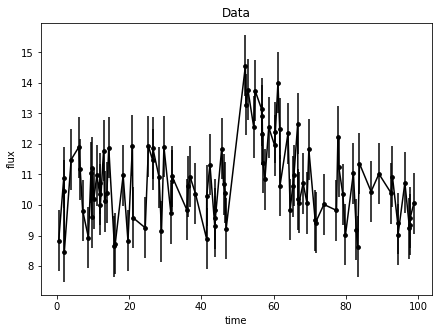

In [3]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.scatter(t, flux, c='black', s=14)
ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.errorbar(t, flux, yerr = err_flux, fmt='k')
ax.set_title('Data')

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [4]:
#defining burst back model
def burst_back(t, A, b, t_0, alpha):
    y = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t_0:
            y[i] = b
        else:
            y[i] = b + A*np.exp(-alpha*(t[i]-t_0))
    return y

In the cell below I just plot the function burst_back with different parameters to get the initial guess to feed emcee with.

Text(0.5, 1.0, 'Fit by hand')

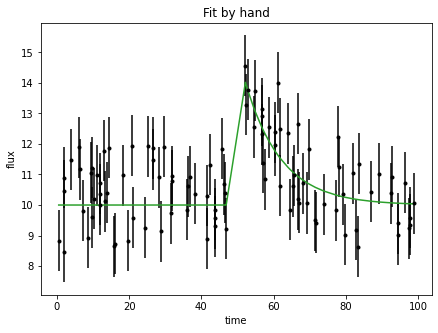

In [5]:
#fit by "hand"
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(t, burst_back(t, 5, 10, 50, 0.1), c='tab:green')
ax.errorbar(t, flux, yerr=err_flux, fmt='.k')
ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.set_title('Fit by hand')

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

To find the prior for $\alpha$ we just use the following formula:

$$p(\alpha) = p(\ln \alpha) |\frac{\mathrm{d}\ln \alpha}{\mathrm{d}\alpha}|$$
$$p(\alpha) \propto \frac{1}{\alpha}$$

with $\alpha$ going from $e^{-5}$ to $e^{5}$.


In [6]:
def loglike(par, t, flux, err_flux):
    log_L = -0.5*np.sum((burst_back(t, par[0], par[1], par[2], par[3]) - flux)**2/err_flux**2) #log-likelihood not normalized
    return log_L

def prior(par): #priors
    prior_A     = stats.uniform.pdf(par[0], loc=0, scale=50)
    prior_b     = stats.uniform.pdf(par[1], loc=0, scale=50)
    prior_t_0   = stats.uniform.pdf(par[2], loc=0, scale=100)
    prior_alpha = stats.loguniform.pdf(par[3], np.exp(-5), np.exp(5))
    return prior_b*prior_A*prior_t_0*prior_alpha

def log_posterior(par, t, flux, err_flux):
    lp = np.log(prior(par))
    if not np.isfinite(lp):
        return -np.inf   #if the log_prior is not finite this put the log_posterior to -inf without giving errors
    else:
        return (loglike(par, t, flux, err_flux) + lp) #log_posterior = log_likelihood + log_prior
    

In [7]:
ndim = 4       # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nsteps = 15000 # number of MCMC steps to take **for each walker**


starting_guesses = np.zeros([nwalkers, ndim])

#starting guesses estimated from the fit by hand
for i in range(nwalkers):
    starting_guesses[i,0] = np.random.uniform(4,6)
    starting_guesses[i,1] = np.random.uniform(8,12)
    starting_guesses[i,2] = np.random.uniform(45, 55)
    starting_guesses[i,3] = np.random.uniform(0,0.5)

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t, flux, err_flux])

sampler.run_mcmc(starting_guesses, nsteps)

# sampler.chain is of shape (nwalkers, nsteps, ndim)
emcee_trace  = sampler.chain.reshape(-1, ndim)

print("done")

done


4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [8]:
autocorr_time = sampler.get_autocorr_time()
print(autocorr_time)

[78.04224742 50.06172418 84.12240494 60.82363318]


With the cell below I display the "raw" chains and their mean. You could see how for each parameter the chain converges to a given value even if sometimes the burn-in phase is quite evident.

(15000, 20, 4)
(15000, 4)


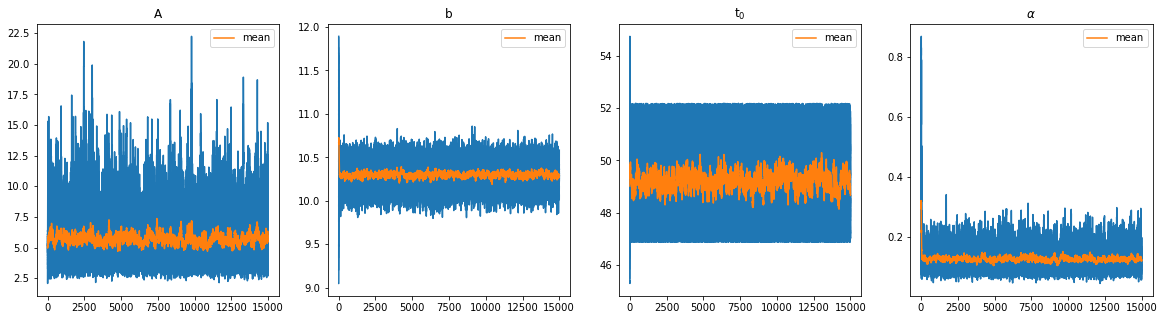

In [9]:
chains = sampler.get_chain()

meanch = np.mean(chains, axis=1)

print(chains.shape)
print(meanch.shape)

fig, ax = plt.subplots(1,4, figsize=(20,5))
titles = ['A', 'b', '$\mathrm{t}_{0}$', r'$\alpha$']

for i in range(ndim):
    ax[i].plot(chains[:, :, i], c='tab:blue')
    ax[i].plot(meanch[:,i], c='tab:orange', label='mean')
    ax[i].legend()
    ax[i].set_title(titles[i])



And here I show the corrected chains: I choose a burn-in phase of 1000 and a thinning period of about twice the mean autocorrelation time of the parameters.

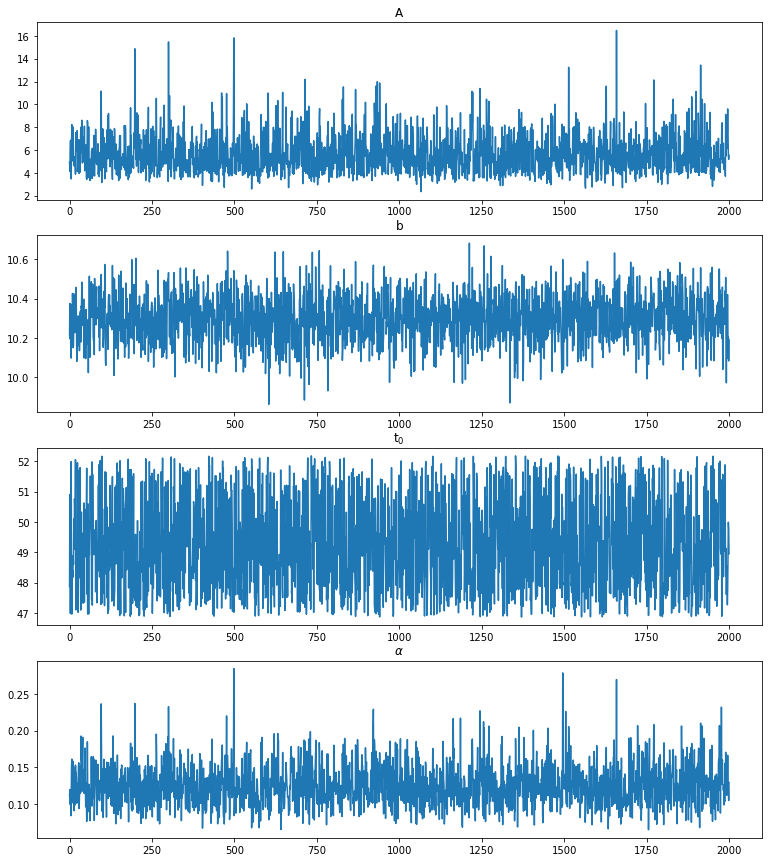

In [10]:
burn = 1000
thin = 140  #I selected the highest auto-correlation time among the ones printed above, and multiply by 2 (more or less)

chains_flat = chains[burn::thin].reshape(-1, ndim)

fig, ax = plt.subplots(4,1, figsize=(13,15))
for i in range(ndim):
    ax[i].plot(chains_flat[:,i])
    ax[i].set_title(titles[i])

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 


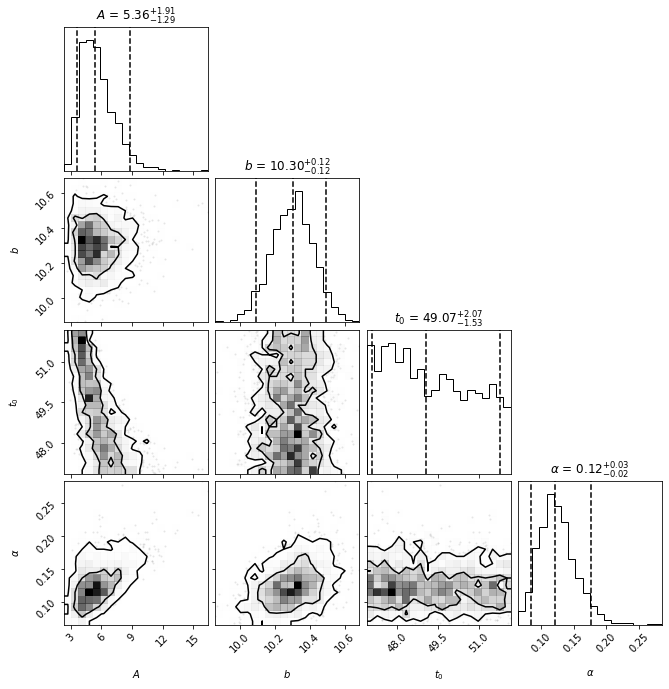

In [11]:
fig = corner.corner(chains_flat, levels=[0.68, 0.95] , quantiles=(0.05, 0.5, 0.95), labels=[r'$A$', r'$b$', r'$t_{0}$', r'$\alpha$'], 
                    title_quantiles=(0.05, 0.5, 0.95), show_titles=True)


From the corner plot it's clear the correlation between the parameters, for example if $A$ is small then also $\alpha$ should be small infact if the peak is not reaching a high value also the exponential has to have a more soft decline to better describe the data points. Or we can notice also how if $A$ is smaller $t_{0}$ should be higher.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.


In [12]:
index = np.random.randint(low=0, high=len(chains_flat), size=100, dtype=int)
random_samples = chains_flat[index]

Text(0.5, 1.0, '100 random results from the burned and thinned chain')

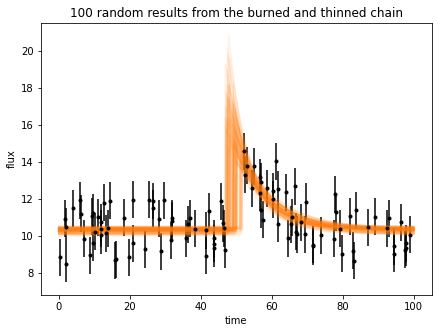

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.errorbar(t, flux, yerr=err_flux, fmt='.k')

t_sample = np.linspace(0,100,1000)
for i in range(len(random_samples)):
    ax.plot(t_sample, burst_back(t_sample, random_samples[i,0], random_samples[i,1], random_samples[i,2], random_samples[i,3]),
           alpha = 0.1, c='tab:orange')
ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.set_title('100 random results from the burned and thinned chain')